<a href="https://colab.research.google.com/github/Jahnvi99/LeetCode-Daily-Challenge/blob/main/Probability_of_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gpytorch

In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from scipy.stats import norm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))    

X = torch.linspace(-3, 3, 1000)
mean = 0.0
std = 1.0
y = gaussian(X, mean, std)

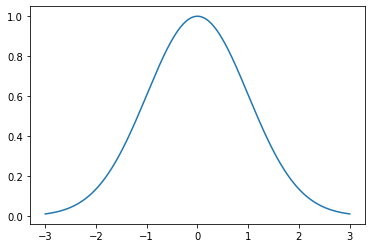

In [ ]:
plt.plot(X,y)
plt.show()

In [ ]:
# Using the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [ ]:
X.shape

torch.Size([1000])

In [ ]:
X_sample = (torch.distributions.Uniform(-3, 3)).sample((3,))
y_sample = gaussian(X_sample, 0.0, 1.0)

In [ ]:
X_sample.shape

torch.Size([3])

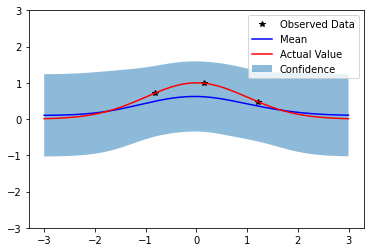

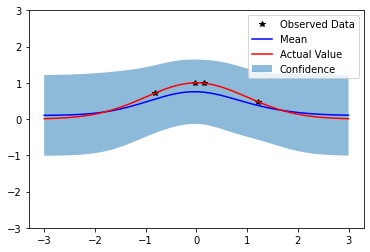

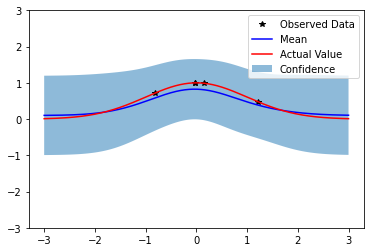

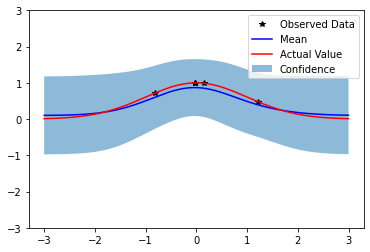

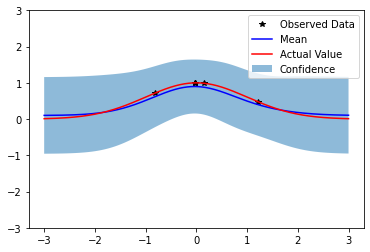

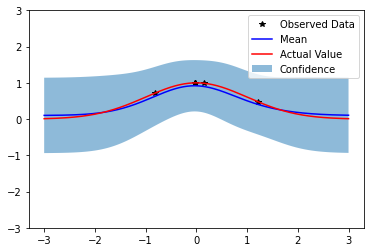

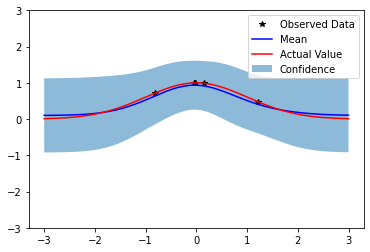

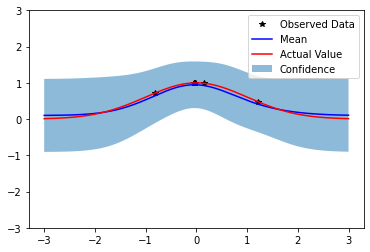

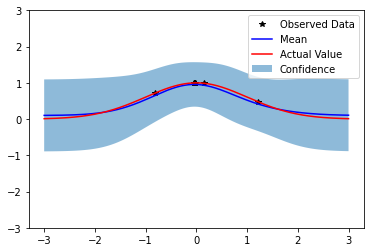

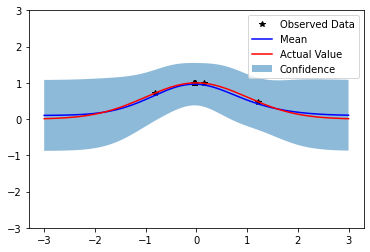

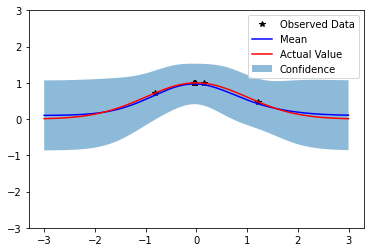

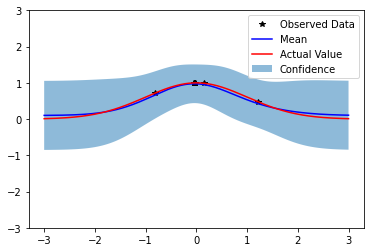

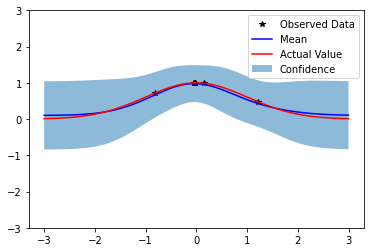

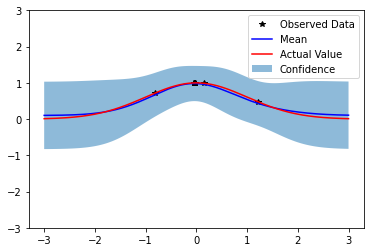

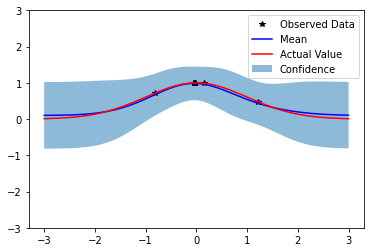

In [ ]:
for i in range(15):
  model = ExactGPModel(X_sample, y_sample, likelihood)
  model.train()
  likelihood.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  for i in range(50):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_sample)
    # Calc loss and backprop gradients
    loss = -mll(output, y_sample)
    loss.backward()
  optimizer.step()

  model.eval()
  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = X
    observed_pred = likelihood(model(test_x))
  with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots()
    # Get standard deviation
    std = np.sqrt(observed_pred.variance.numpy())
    # Get upper and lower confidence bounds
    #lower, upper = observed_pred.confidence_region()
    mean = observed_pred.mean.numpy()
    lower, upper = mean - std, mean + std
    # Plot training data as black stars
    ax.plot(X_sample.numpy(), y_sample.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), mean, 'b')
    # Plot actual function as red line
    ax.plot(test_x.numpy(), y.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Actual Value','Confidence'])
  mu = observed_pred.mean
  sigma = torch.sqrt(observed_pred.variance)
  best_mu = torch.max(mu)
  idx = torch.argmax(torch.from_numpy(norm.cdf((mu - best_mu - 1E-9) / (sigma))))
  p = torch.unsqueeze(X[idx], 0)  
  X_sample = torch.cat((X_sample, p))
  y_sample = gaussian(X_sample, 0.0, 1.0)     